In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import shap
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
import pickle

In [4]:
video_folders = ['vid1', 'vid2', 'vid3', 'vid3.2', 'vid3.3', 'vid4', 'vid5', 'vid6']

In [5]:
# This feels barbaric but for the sake of reproducability:
bg_alphabet = ['A','B', 'V', 'G', 'D', 'E', 'J', 'Z', 'I', 'Ik', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'F', 'H', 'C', 'CH','SH', 'SHt', 'Y', 'Yrm', 'YU', 'YA']

In [6]:
def get_bounding_box_ratio(row):
    x1, y1, x2, y2 = row.bbox_x1, row.bbox_y1, row.bbox_x2, row.bbox_y2
    return (x2 - x1) / (y2 - y1)

In [7]:
def get_ratios(df):
    ratios_df = df.copy()
    ratios_df['ratio'] = ratios_df.apply(get_bounding_box_ratio, axis = 1) 
    return ratios_df

In [8]:
def drop_columns(df):
    lms_to_keep = [ 4, 6, 8, 10, 12, 14, 16, 18, 20]
    xs = [f'x{i}' for i in range(21) if i not in lms_to_keep]
    ys = [f'y{i}' for i in range(21) if i not in lms_to_keep]
    drop_cols = ['video', 'handedness', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']
    return df.drop(columns = xs + ys + drop_cols)

In [9]:
def drop_na(df):
    return df.dropna(subset=['iou2'])

In [10]:
def draw_heatmap(df, cols):
    corr_matrix = df[cols].corr()

    plt.figure(figsize = (12, 8))
    sns.heatmap(corr_matrix, cmap = 'coolwarm', linewidths = 0.5, vmin = -1, vmax = 1)
    plt.title('Correlation matrix')
    plt.show()

In [11]:
def get_train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size = 0.20, 
        random_state = 42, 
        stratify = y
    )
    return X_train, X_test, y_train, y_test

In [12]:
def plot_letter_data(letter, num = len(video_folders)):
    count = 1
    for video, group in hands.loc[hands.letter == letter].groupby('video'):
        if count > num:
            break
        hand_sample = group.iloc[0]
        hand_sample_xs = hand_sample[xs_cols]
        hand_sample_ys = hand_sample[ys_cols]
        
        # # (1 - y) because mediapipe y = 0 is at top, and here it's at bottom 
        plt.scatter(hand_sample_xs, [1 - hand_sample_ys], label = video, color = colors_by_video[video])

        # plotting the line connections
        for line_idxs in hand_lines:
            plt.plot([hand_sample_xs[ind] for ind in line_idxs], [1 - hand_sample_ys[ind] for ind in line_idxs], color = colors_by_video[video], alpha = 0.3)
        count += 1
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Letter {letter} landmarks by video')
    plt.show()

In [13]:
def get_bar_chart_of_letter_movement(letter):
    letter_df = hands.loc[(hands.letter == letter)]
    labels = []
    means = []
    for video, group in letter_df.groupby('video'):
        means.append(1 - group.iou0.mean())
        labels.append(video)
        
        plt.bar(labels, means, color = 'plum')
    
    # plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.ylabel('Avegare (1 - IoU) between frames')
    plt.xlabel('Video sample')
    plt.title(f'Average movement in "{letter}" videos')
    
    plt.show()


In [14]:
def get_scattet_plot_of_letter(letter):
    letter_df = hands.loc[(hands.letter == letter)]
    fig, ax = plt.subplots()
    
    for video, group in letter_df.groupby('video'):
        ax.scatter(group.x1, group.y1, label = video, color = colors_by_video[video])
    
    plt.legend(title = 'Video')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('Bounding box width')
    plt.ylabel('Bounding box height')
    plt.title(f'Palm position in hand bounding box in "{letter}" videos')
    
    plt.show()

In [15]:
def plot_letter_landmark_data(letter, show = True):
    video_lms =  hands.loc[hands.letter == letter].groupby('video').first().reset_index()
    for i in range(len(xs_cols)):
        sns.scatterplot(x = video_lms[xs_cols[i]], y = [1 - j for j in video_lms[ys_cols[i]]])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Letter {letter} landmarks by index')
    plt.show()

In [54]:
colors = {17: 'Fuchsia', 18: 'MediumOrchid', 19: 'DarkTurquoise', 20: 'DodgerBlue'}

def get_color_for_lm(lm_no):
    # pinky landmarks:
    if lm_no >= 17 and lm_no <= 20:
        return colors[lm_no]
    return 'Gainsboro'

def compare_landmark_placement(l1, l2):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))
    video_lms =  hands.loc[hands.letter == l1].groupby('video').first().reset_index()
    for i in range(len(xs_cols)):
        axes[0].scatter(x = video_lms[xs_cols[i]], y = [1 - j for j in video_lms[ys_cols[i]]], color = get_color_for_lm(i))
        axes[0].set_title(f'landmark position for letter {l1}')
    video_lms =  hands.loc[hands.letter == l2].groupby('video').first().reset_index()
    for i in range(len(xs_cols)):
        axes[1].scatter(x = video_lms[xs_cols[i]], y = [1 - j for j in video_lms[ys_cols[i]]], color = get_color_for_lm(i))
        axes[1].set_title(f'landmark position for letter {l2}')
        

In [55]:
def get_bounding_box_ratios(letter):
    ratios = []
    video_lms =  hands.loc[hands.letter == letter].groupby('video').first().reset_index()
    for i in range(video_lms.shape[0]):
        row = video_lms.loc[i]
        x1, y1, x2, y2 = row.bbox_x1, row.bbox_y1, row.bbox_x2, row.bbox_y2
        ratio = (x2 - x1) / (y2 - y1)
        ratios.append(ratio)
    return ratios, np.mean(ratios)

In [56]:
xs_cols = [f'x{i}' for i in range(21)]
ys_cols = [f'y{i}' for i in range(21)]
landarks_cols = xs_cols + ys_cols

In [57]:
colors_by_video = {
    'vid2' : 'green',
    'vid1': 'blue', 
    'vid3': 'orange',
    'vid3.2': 'orange',
    'vid3.3': 'orange',
    'vid4': 'purple',
    'vid5': 'red',
    'vid6': 'plum'
}

In [58]:
thumb = [0, 1, 2, 3, 4]
pointer = [0, 5, 6, 7, 8]
middle = [9, 10, 11, 12]
ring = [13, 14, 15 ,16]
pinky = [0, 17, 18, 19, 20]
top_palm = [5, 9, 13, 17]
hand_lines = [thumb, pointer, middle, ring, pinky, top_palm]

# Bulgarian Sign Language (Alphabet) Detector #

<br/>
This project aims to create a model that can detect the letters in the bulgarian alphabet in a video/stream. To do so, several steps have been taken, starting from the collection of the dataset. 
<ol>
    <li>
        Collect videos of people doing the signs - They have not been added to the repo/zip because of the size but can still be acessed through <a href='https://drive.google.com/drive/folders/101l61bluVN9f49zUGeR_AVPxk6osSpeX?usp=sharing'>this link</a>. Most of the people have used <a href='https://www.youtube.com/watch?v=8YmTxIp2Gtg'>this video</a> to learn the sign from, one person used a different tutorial video in which the forms are different (mostly their angle)
    </li>
    <li>
        Extract images (frames) from these videos and labeling them - ./DataCollection.ipynb
    </li>
    <li>
        Using those frames to create the dataset - ./ExtractingFeaturesAndExploration.ipynb
    </li>
    <li>
        Using the dataset to create a model
    </li>
    <li>
        Trying it out in real time - link to file
    </li>
</ol>

The dataset is a table where each sample is a frame, containing information about the hand landmarks, bounding box coordinates and the calculated Interception over Union for 3 samples back. Samples are taken from each video with a 5 frame step. So the samples will have IoU between itself and 5, 10 and 15 frames back. Most of the videos are 30fps - we have "history" up to half a second ago.

This project has several things to keep in mind:
<uol>
    <li>Small dataset (who knew collecting data wasn't easy)</li>
    <li>Multinomial Classificaiton with 30 classes</li>
    <li>For a few letters, the only way to distinguish them is by their movement</li>
    <li>The hand landmarks which will be the primary source of information are not truly independent</li>
</uol>

#### Media pipe's handlandmarker indexes reference: ####
<!-- ![image.png](attachment:3966980e-30b0-4172-9011-74b26321c28e.png)\ -->
![./image/mediapipe_hand_lms.png](./images/mediapipe_hand_lms.png)



In [2]:
hands = pd.read_csv('hands_data.csv')
hands = hands.drop(columns = 'Unnamed: 0')

### Data collection (summary) ###
<b>raw videos: </b>
I could not find any dataset that contains Bulgarian sign language so I decided to create one. (Not included in raw form due to size, can be accessed from links above)
The raw sources are videos in which people are doing the signs. Every folder contains letter videos made by the same person (1 video = 1 letter; 1 folder = letters done by the same person). Most of them have used the same source to learn the signs from, however, even so, variations are present. One of the people (vid2) has used a different source and their signs vary more, espcially when it comes to angles.


<b>collection:</b>
I go through the videos and take frames at a pace set by FREQ (set to 5 for this project). This results in a ./data folder -> folders for every letter -> letter frames

### Extract landmarks and form csv (summary) ###

I go through all frame samples using Mediapipe's Hand Landmarker, which finds 21 landmarks on the human hand. I collect those for every frame sample and do the following:

#### Three main parts: ####
<uol>
    <li> <b>Remove image size information - </b>
    Mediapipe's landmarks return the normalized coordinates. That means that the width and height of the image have been scaled from 0 to 1 and the landmarks have been scaled accordingly. This is good if the position within the image is important. In my case it is not so I scale the landmarks within their own bounding box.
    </li>
    <li> <b>Flip all hands to 'Left' -</b>   
    If the hand is recognized as 'Left', I flip the landmarks so all hands are 'Right' - making it easier for the algorithm with my limited data
    </li>
    <li> <b> Add (very primitive) movement 'history' - </b>
    And last, I add the IoU for 3 steps back (steps = FREQ, in this case, the samples were taken from the videos with 5 frames apart). This is in hopes that the algorithm will be able to pick up on the few letters with movement.
    </li>
</uol>

### Exploration ###

The data has been already seen in the form of photos / videos, so in this part I mostly try to confirm my expectations:
<ol>
    <li>The iou for letters that include horizontal/vertical movement should be lower (e.g. SH and SHt)</li>
    <li>The iou for letters that include rotiational movement should be higher (rotation is not caught by iou, e.g. K and D)</li>
    <li>y0 - the palm root landmark should usually be 0 or 1 (if the hand is flipped)</li>
</ol>

The landmarks and IoUs are all between 0 and 1, as expected. The bounding boxes still have negative values due to detecting landmarks outside of the frame.

In [9]:
hands.describe().T

,count,mean,std,min,25%,50%,75%,max
x0,4944.0,0.395681,0.236998,0.000000,0.225552,0.379008,0.543916,1.000000
x1,4944.0,0.655761,0.225441,0.000000,0.489472,0.674079,0.841834,1.000000
x2,4944.0,0.789293,0.210218,0.000000,0.663360,0.834595,0.971381,1.000000
x3,4944.0,0.786067,0.187314,0.000000,0.726971,0.830789,0.906434,1.000000
x4,4944.0,0.725584,0.261116,0.000000,0.509632,0.780373,1.000000,1.000000
x5,4944.0,0.621260,0.230645,0.000000,0.470528,0.643222,0.803481,1.000000
x6,4944.0,0.665521,0.218156,0.000000,0.506913,0.659272,0.867778,1.000000
x7,4944.0,0.695783,0.226005,0.026419,0.513871,0.750269,0.900530,1.000000
x8,4944.0,0.709681,0.264372,0.000000,0.503763,0.762126,0.968322,1.000000
x9,4944.0,0.432640,0.157113,0.000000,0.318920,0.446977,0.554427,1.000000


In [10]:
hands.dtypes

video          object
letter         object
handedness     object
x0            float64
x1            float64
x2            float64
x3            float64
x4            float64
x5            float64
x6            float64
x7            float64
x8            float64
x9            float64
x10           float64
x11           float64
x12           float64
x13           float64
x14           float64
x15           float64
x16           float64
x17           float64
x18           float64
x19           float64
x20           float64
y0            float64
y1            float64
y2            float64
y3            float64
y4            float64
y5            float64
y6            float64
y7            float64
y8            float64
y9            float64
y10           float64
y11           float64
y12           float64
y13           float64
y14           float64
y15           float64
y16           float64
y17           float64
y18           float64
y19           float64
y20           float64
bbox_x1   

### How many samples of each letter? ###

Checking how (un)balanced the data it when it comes to the target classes (letter) <br/>
The spikes are usually when the letter involve movement and the videos have been longer (more frames extracted)

In [59]:
hands.letter.value_counts().values.mean()

164.8

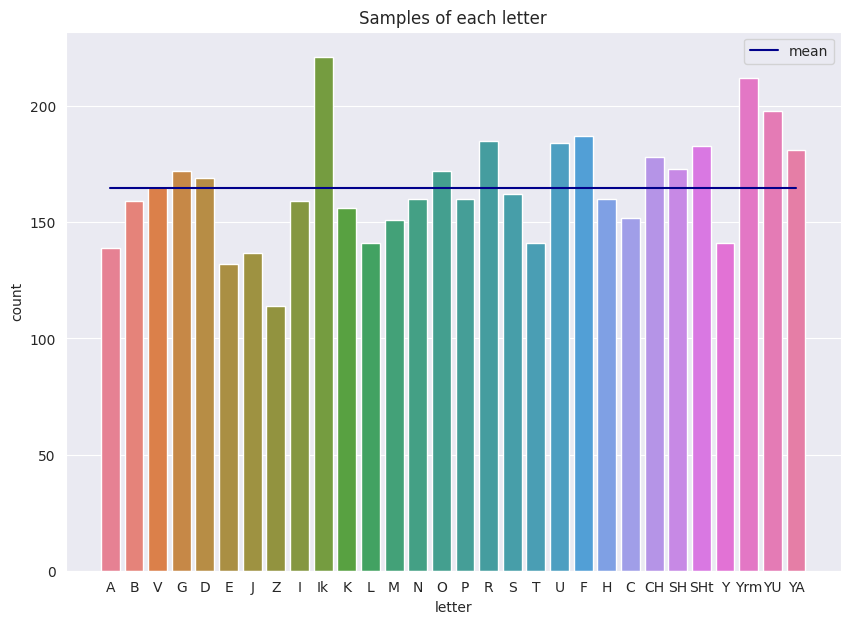

In [60]:
plt.figure(figsize = (10,7))
sns.set_style("darkgrid")
sns.countplot(hands, x = 'letter', hue = 'letter', palette = sns.color_palette("husl", 30),  legend = False)
plt.plot([i for i in range (30)], [hands.letter.value_counts().values.mean() for i in range(30)], color = 'darkblue', label = 'mean')
plt.title('Samples of each letter')
plt.legend()
plt.show()

The root of the palm usually marks the lowest point of the bounding box or the highest (when the letter sign has the hand pointed downwards)

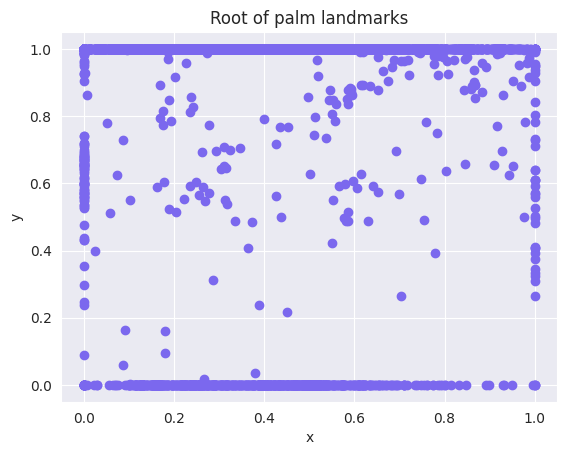

In [61]:
plt.scatter(hands.x0, hands.y0, color = "MediumSlateBlue")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Root of palm landmarks')
plt.show()

### Finding patterns with landmarks ###

Starting off simple by visualizing the landmarks of one sample of the letter 'V'. 'V' is when the hand is facing the viewer with fingers extended, much like a wave (👋).  Even without taking a look at mediapipe's landmarks documentation, we can roughly make out a hand already.

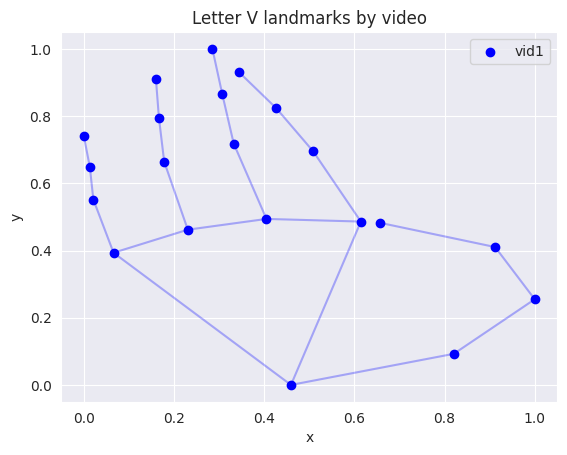

In [62]:
plot_letter_data('V', 1)

### A hand from every video: ###

We are looking at a plot which shows the landmarks from every video's first frame sample. Due to having scaled the landmarks, it is not as easy to see the actual hand, but we can observe that clusters are forming. Showing that there is some kind of similarity between the landmarks of the same letter in the different videos/people doing them. <br/>

(Although, if we squint, we can see a fist with an extended thumb)

Showing only the first 4 videos because all of them make the plot harder to read.

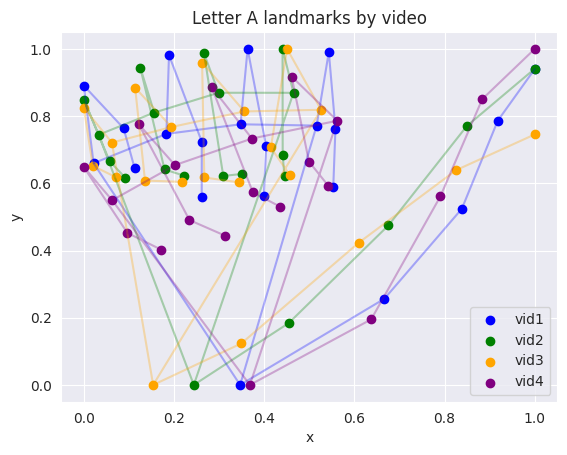

In [63]:
plot_letter_data('A', 4)

#### Plots that look similar: ###

E looks a lot like V, however, keep in mind that this is not the whole picture. On this plot we see the dots grouped by video, not by their number. That means that although the 'clusters' look the same, the difference in the bounding box and specific landmark postion may differ.

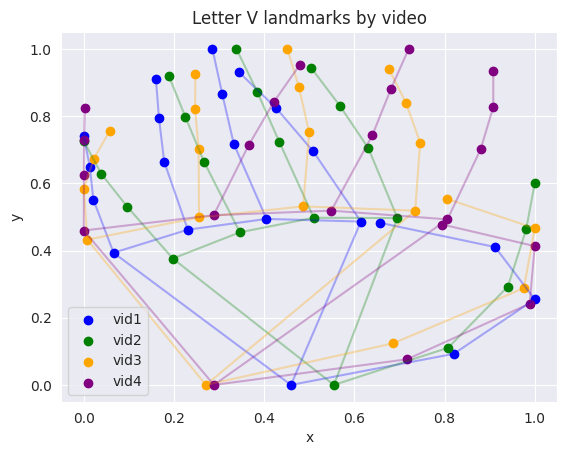

In [64]:
plot_letter_data('V', 4) # "wave" - 👋

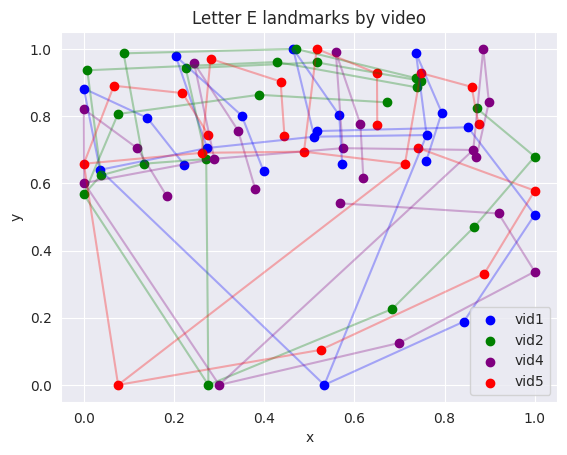

In [65]:
plot_letter_data('E', 4) # fist - ✊

#### Plot E and V by landmark position ####

To compare, this time <b> each color represents a landmark index </b> (not a video). This is to see that parts of the fingers are placed differently between the two letters. <br/>
For example, on the rightmost in E, we see purple/pink (bottom part of the pinky) and next to them are light/dark blue (top part of the pinky). They appear next to each other because in E, <b>the pinky is flexed inwards</b>, towards the palm. On the 'V' plot we can see that those same colors are on top of each other - <b>the pinky is extended upwards</b>.
<br/>

(The same could be observed for the other fingers if we were to color them too.)

The weakness of this plot is that, because of scaling, it doesn't portray the ratio of the bounding boxes. The bounding box of V, where the hand is extended (much like saying 'hello' 👋) the bounding box's height > width. Wtih 'E' where the hand is like a fist (✊), the width is roughly the same as the height. Scroll next to see ratio comparison.

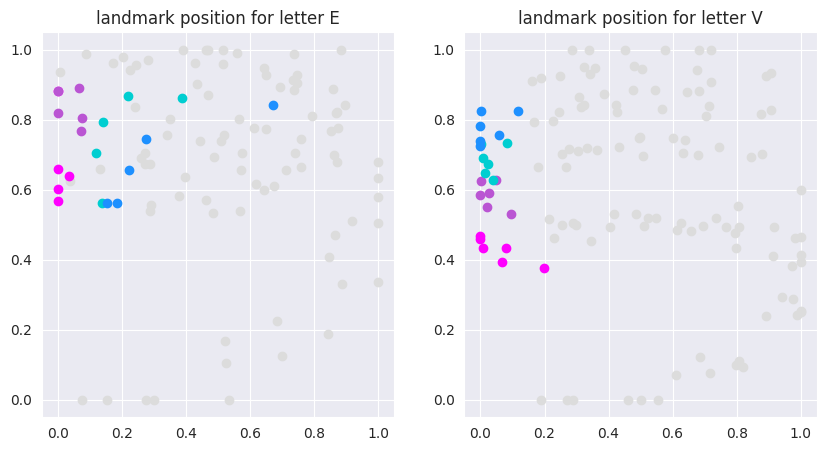

In [72]:
compare_landmark_placement('E', 'V')

#### Bouding box ratios: ####

As mentioned above, ratios can not be interpreted from the plot above so I've made a simple comparison. As expected, the ratio width:height of 'E' is closer to 1 than 'V'. <br/>
What is interesting is the one higher value of 'V': after inspection it turns out that variations of 'V' exist and the person from whose video the sample was taken, was extending their thumb outwards (instead of inwards like the others) causing the width to grow. And we can see from the 'V' plot up that vid4 differs a little bit - the thumb landmarks are further away from the rest. 

In [73]:
E_ratios, E_mean = get_bounding_box_ratios('E')
V_ratios, V_mean = get_bounding_box_ratios('V')

print ('E ratios: ', E_ratios)
print ('E mean: ', E_mean)
print ('\nV ratios: ', V_ratios)
print ('V mean: ', V_mean)

E ratios:  [1.13361623113368, 0.9637068415471358, 1.0044332494232495, 1.1444000368675602, 2.020336294177708]
E mean:  1.2532985306298667

V ratios:  [0.7349684035188698, 1.035595682985534, 0.5905079258492039, 0.7086408029085901, 0.76710376944527, 0.9312133480942357]
V mean:  0.7946716554669506


### Same form, movement and rotation in one ###

'I' and 'Ik' have same form (landmarks) but 'Ik' has movement and rotation. Movement is tracked with IoU (Ik's IoU is lower). The movement in this case can also be captured by the position of the palm root. Because the hand rotates (a bit like a dirigent) the position of the palm with regards to the fingers (and therefore the hand bounding box) changes.

In [74]:
movement_means = hands.groupby('letter')[['iou1', 'iou2', 'iou0']].mean()
movement_means = movement_means.sort_values(by = 'iou1').T[[ 'I', 'Ik' ]]
movement_means.columns = ['I (stat)', 'Ik (mov)']
movement_means

,I (stat),Ik (mov)
iou1,0.626258,0.235297
iou2,0.623489,0.236701
iou0,0.628724,0.237778


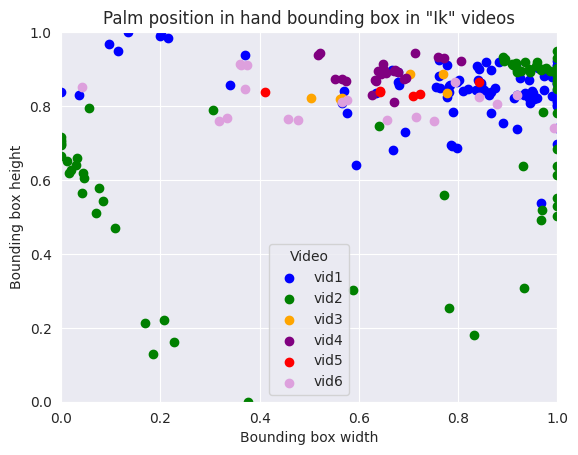

In [76]:
get_scattet_plot_of_letter('Ik')

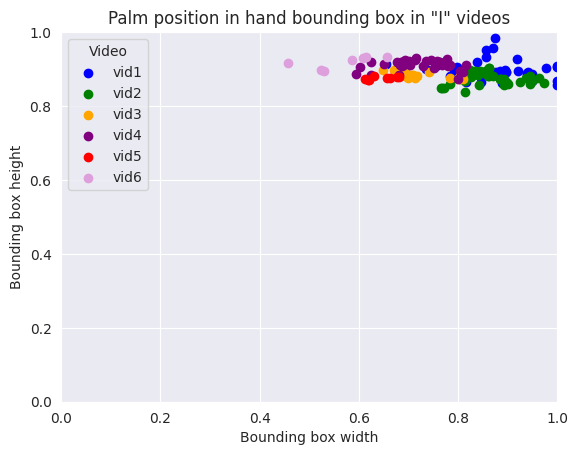

In [77]:
get_scattet_plot_of_letter('I')

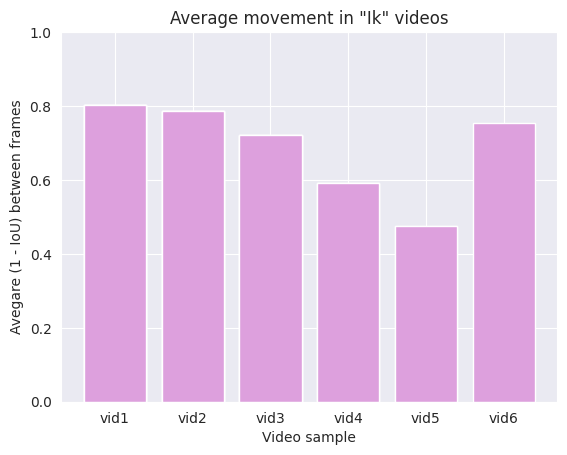

In [78]:
get_bar_chart_of_letter_movement('Ik')

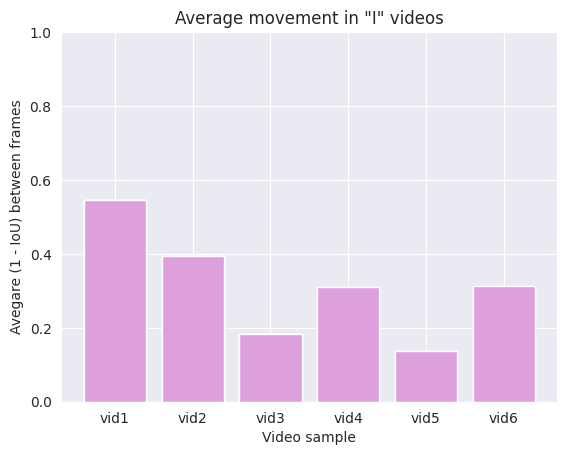

In [79]:
get_bar_chart_of_letter_movement('I')

### Same form, movement in one ###
'SH' and 'SHt', 'Y' and 'Yrm' are two pairs with the same form (landmarks) but one is static ('SH' and 'Y') and the other has movement ('Sht' and 'Yrm'). Plotting the landmarks expecting them to be the same. For these letter I will rely on the IoU fields. (Explored in detail further down)

In this snippet we can confirm that letter with movement have significantly lower IoU on average:

In [80]:
movement_means = hands.groupby('letter')[['iou1', 'iou2', 'iou0']].mean()
movement_means = movement_means.sort_values(by = 'iou1').T[[ 'SH', 'SHt', 'Y', 'Yrm' ]]
movement_means.columns = ['SH (stat)', 'SHt (mov)', 'Y (stat)', 'Yrm (mov)']
movement_means

,SH (stat),SHt (mov),Y (stat),Yrm (mov)
iou1,0.741195,0.222931,0.753506,0.307160
iou2,0.742529,0.222053,0.753119,0.300203
iou0,0.739469,0.231791,0.753038,0.313949


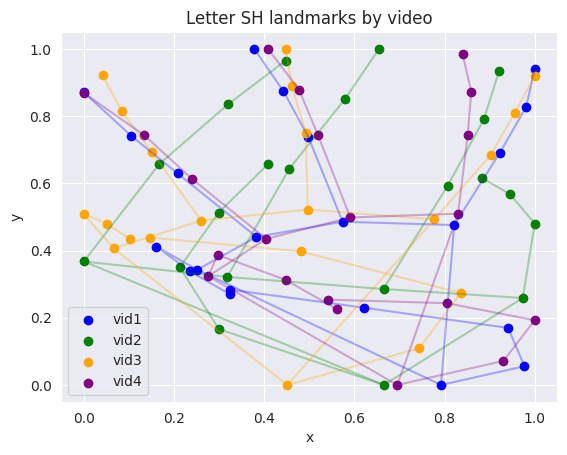

In [81]:
plot_letter_data('SH', 4)

Here it also easier to spot that vid2 has used a different video reference. Particularly one in which the outside of the palm is facing the viewer, unlike the other samples.

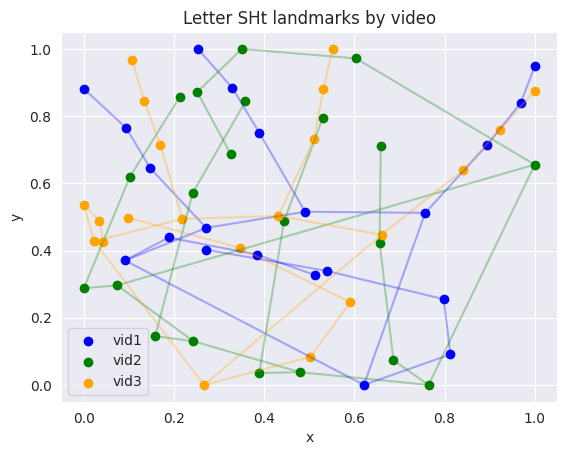

In [82]:
plot_letter_data('SHt', 3)

### Same form, movement in both ###

This is where I expect my data to flop - 'D' and 'K', which have the same form (landmarks) and are differentiated by the movement. ('K' rotates on the palm landmark, 'D' makes a circle with the index and middle finger in the air) There is no <i>big</i> horizontal/vertical movement of the bounding box - <b> IoU will give equal values </b>. I expect the landmarks to be roughly the same. The only difference will be a small change in the bounding box ratios but since I am not keeping "history" of bounding box ratio, this will not be something the algorithm will be able to use.

In [83]:
movement_means = hands.groupby('letter')[['iou1', 'iou2', 'iou0']].mean()
movement_means = movement_means.sort_values(by = 'iou1').T[[ 'D', 'K' ]]
movement_means.columns = ['D', 'K']
movement_means

,D,K
iou1,0.450257,0.422095
iou2,0.445164,0.410064
iou0,0.456503,0.433272


Not really any information telling us that there's a circular movement in the first and a 'wave' in the second.

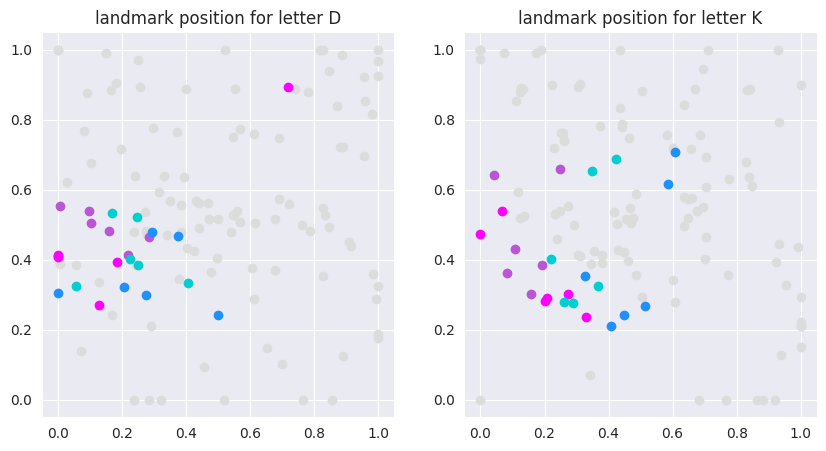

In [84]:
compare_landmark_placement('D', 'K')

### IoU features ###

In [85]:
median_values = hands.groupby('letter')[['iou1', 'iou2', 'iou0']].median()
median_values = median_values.sort_values(by = 'iou1')

In [86]:
movement_letters = ['D', 'Z', 'Ik', 'K', 'SHt', 'Yrm']

The IoU succcessfully caught the movement in the gestures. This will be very helpful in distinguishing between the pairs with same form but one is moving. It won't be very helpful in distinguishing between those that have same from <u>and</u> movement.

There is a 0.1 difference between the movement letters MAX and the static MIN. I hope for that to be leveraged as a separator between these two subsets.

In [93]:
# MOVEMENT 
median_values.T[movement_letters].T.describe()

,iou1,iou2,iou0
count,6.000000,6.000000,6.000000
mean,0.291097,0.285188,0.299342
std,0.142648,0.139606,0.144655
min,0.098769,0.102017,0.106660
25%,0.203355,0.200703,0.205906
50%,0.278428,0.264672,0.288909
75%,0.403799,0.393264,0.414769
max,0.467037,0.464256,0.476612


In [94]:
# STATIC
median_values.T[[letter for letter in bg_alphabet if letter not in movement_letters]].T.describe()

,iou1,iou2,iou0
count,24.000000,24.000000,24.000000
mean,0.676546,0.673442,0.677816
std,0.066579,0.066831,0.065843
min,0.566209,0.563520,0.566209
25%,0.622021,0.619009,0.620938
50%,0.665493,0.665493,0.671757
75%,0.725260,0.722494,0.726136
max,0.801084,0.802120,0.800399


#### Use bounding box ratio ###

Maybe the differentiation between K and D can be saved by taking the bounding box ratios. (With K the hand rotates and the width becomes larger, whether with D the tilt needed for the circular motion is more subtle). 

In [95]:
K_ratios, K_mean = get_bounding_box_ratios('K')
D_ratios, D_mean = get_bounding_box_ratios('D')

print ('E ratios: ', K_ratios)
print ('E mean: ', K_mean)
print ('\nV ratios: ', D_ratios)
print ('V mean: ', D_mean)

E ratios:  [1.1786693953070217, 0.8959095994212755, 1.2108972683564847, 0.9582424953184772, 1.067522348746512, 0.5076062570971056]
E mean:  0.9698078940411462

V ratios:  [1.0199139063283746, 1.5632199529352795, 0.598844103060496, 0.7743759205576876, 0.6203327183915619, 0.8842512533201013]
V mean:  0.9101563090989169


## Data processing ##

In [97]:
hands = get_ratios(hands)

### Correlations ###

Trying to take a bird's eye view of an overwhleming matrix: 
<uol>
<li>the xs and ys don't correlate with one another (the top right and bottom left corners are brighter)</li>
<li>but they correlate highly within themselves - that is understandable, landmarks which are closer on the hand are more likely to "move together". Especially for the little joints before the end of the fingers. The knuckles are also mostly static, they don't carry information.</li>
<li>the palm (0) correlates highly with the first landmars of the thumb (1-4)</li>
<li>ious correlate with each other</li>
<li>ratios are ok</li>
</uol>

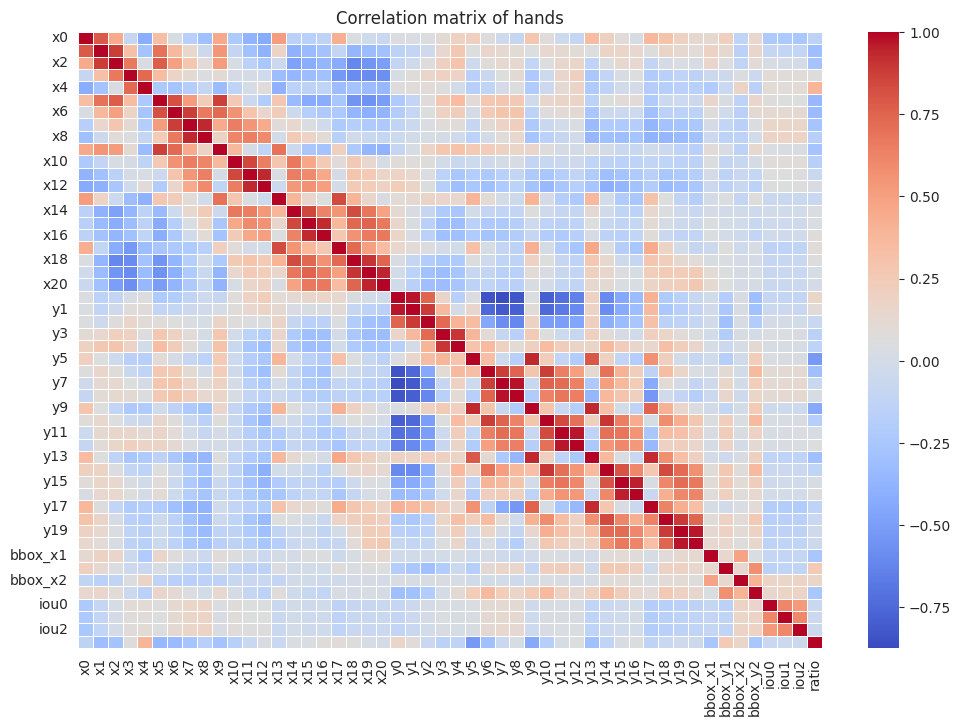

In [98]:
corr_matrix = hands.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation matrix of hands')
plt.show()

### Closer look at the ys ###

Looking closer at the ys we can see a pattern of red squares (high correlations) separated by lighter striper (lower correlations) and then high correlation every time they intersect. The squares are actually the triplets of landmarks that make a finger. Esentially every square is a finger - the big joint in the middle (proximal joint), the little joint (distal joint) and the tip of the finger. 
![](./images/joints.jpg)

The lines inbetween the the knuckles (metacarpophalangeal joint) which don't correlate with the fingers but correlate with each other. That's understandable because they don't really move or if they move, they move together and overall don't cary much information.

The darker blue squares are due to the root of the palm correlating (negatively) with the fingers mentioned above. As it is strongest with the index finger and gets lower as we move to the pinky.

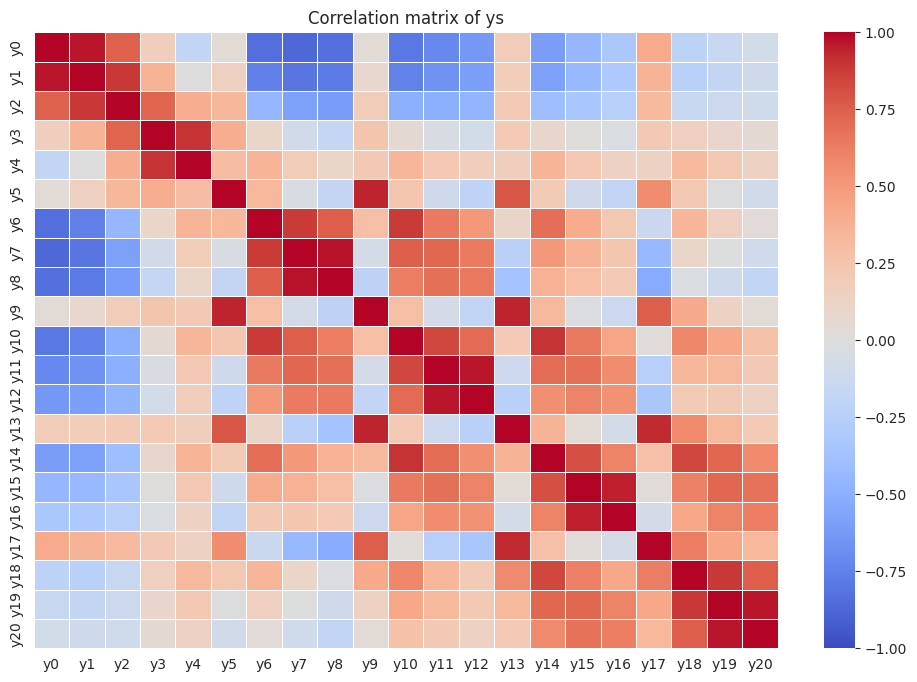

In [99]:
ys = [f'y{i}' for i in range(21)]
corr_matrix = hands[ys].corr()

plt.figure(figsize = (12, 8))
sns.heatmap(corr_matrix, cmap = 'coolwarm', linewidths=0.5, vmin = -1, vmax = 1)
plt.title('Correlation matrix of ys')
plt.show()

#### Closer look at the xs ####

There aren't strong patterns with the xs. Again, landmarks closer to each other have stronger correlations and the palm correlation exists but with the opposite behaviour - stronger with the pinky landmakrs but weaker as we move to the index finger. Not as strong as it correlates with the ys.

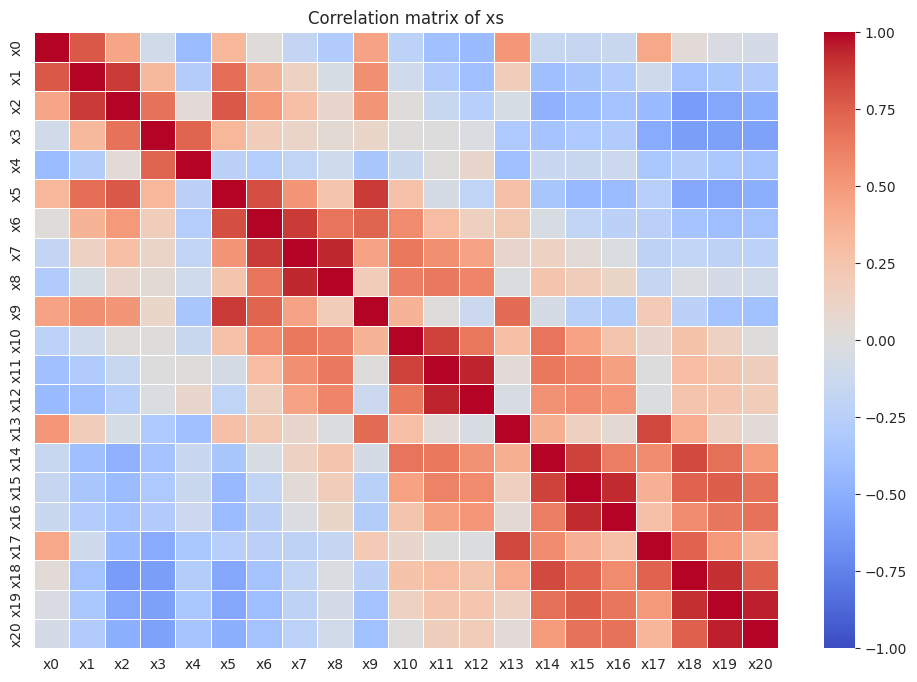

In [100]:
ys = [f'x{i}' for i in range(21)]
corr_matrix = hands[ys].corr()

plt.figure(figsize = (12, 8))
sns.heatmap(corr_matrix, cmap = 'coolwarm', linewidths = 0.5, vmin = -1, vmax = 1)
plt.title('Correlation matrix of xs')
plt.show()

### Manual Feature Selection ###

Trying to remove some of the strongly correlated features that outright don't carry much information - the little joints (distal), knuckles, the palm. <b>In blue are the ones that I kept: </b>
![](./images/points_kept.png)

In [170]:
hands = pd.read_csv('hands_data.csv')
hands = hands.drop(columns = 'Unnamed: 0')
hands = drop_na(hands)

In [171]:
X = hands.drop(columns = 'letter')
y = hands.letter.astype('category')

X_train, X_test, y_train, y_test = get_train_test(X, y)

In [172]:
pipeline = Pipeline([
    ('get_ratios', FunctionTransformer(get_ratios)),
    ('drop_columns', FunctionTransformer(drop_columns)),
])

X_train = pipeline.fit_transform(X_train)

Landmarks close together still are highly correlated but I don't think I should sacrifice more features at this point.

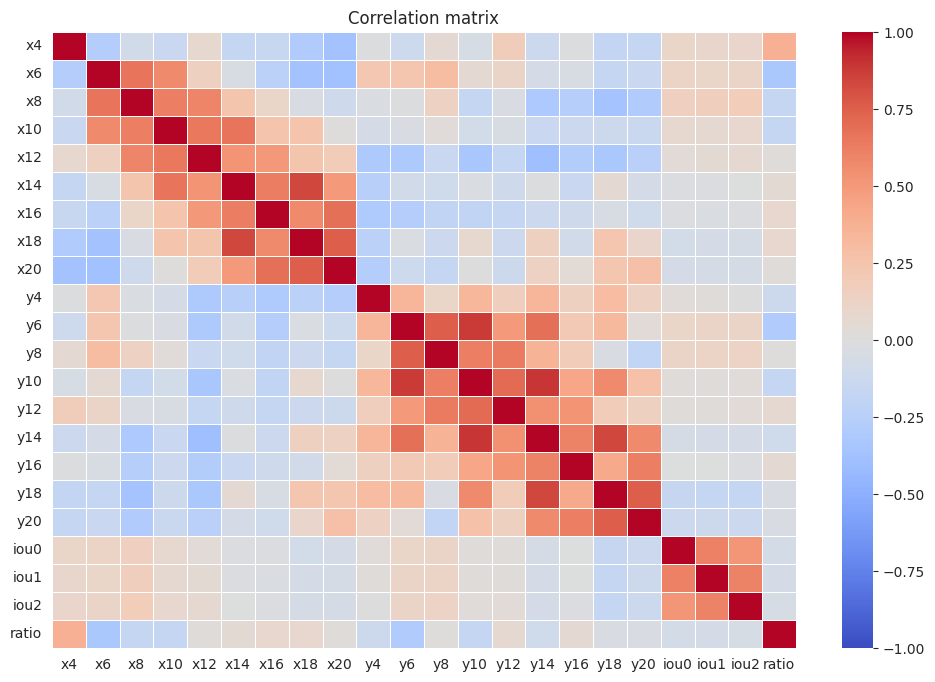

In [104]:
draw_heatmap(X_train, X_train.columns)

In [105]:
X_train

,x4,x6,x8,x10,x12,x14,x16,x18,x20,y4,...,y10,y12,y14,y16,y18,y20,iou0,iou1,iou2,ratio
399,0.755698,0.593613,0.452650,0.419479,0.324398,0.271181,0.208180,0.093052,0.000000,0.465932,...,0.270715,0.000000,0.329744,0.076995,0.455982,0.261008,0.151926,0.567210,0.559999,0.963553
4337,1.000000,0.554321,0.627104,0.425691,0.425462,0.290497,0.307624,0.132295,0.190419,0.650871,...,0.469595,0.761225,0.568683,0.808900,0.608574,0.766497,0.954183,0.367742,0.353198,1.387906
1163,0.459429,0.602489,0.453157,0.281016,0.494102,0.080456,0.371564,0.000000,0.283256,0.506329,...,0.239789,0.536955,0.416905,0.606674,0.636777,0.711576,0.464612,0.569323,0.570245,1.092469
4371,1.000000,0.351625,0.375346,0.455510,0.417613,0.363029,0.327741,0.238509,0.246504,0.409068,...,0.582767,0.800650,0.712611,0.845824,0.811455,0.890444,0.072136,0.594008,0.479276,1.689360
2710,1.000000,0.638475,0.936759,0.582182,0.933502,0.505068,0.809958,0.398333,0.612031,0.824743,...,0.038686,0.034142,0.082062,0.037024,0.222115,0.066641,0.866431,0.848136,0.820668,2.009560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045,0.416113,0.957477,1.000000,0.634059,0.554610,0.377050,0.395197,0.168797,0.000000,0.683661,...,0.296303,0.000000,0.420932,0.618528,0.471974,0.302901,0.865772,0.717965,0.611537,1.078958
3761,0.384070,0.678928,0.434436,0.283602,0.499216,0.076207,0.403775,0.000000,0.297380,0.334292,...,0.236390,0.635210,0.290670,0.630359,0.348860,0.622925,0.419754,0.661284,0.664286,1.434367
467,1.000000,0.502639,0.439125,0.338743,0.309448,0.193883,0.156991,0.047176,0.027337,0.240046,...,0.685887,0.465569,0.674821,0.479797,0.631702,0.459968,0.826534,0.835736,0.899646,1.396852
3064,0.396733,0.899617,0.674201,0.928376,0.719841,0.928096,0.728252,0.782811,1.000000,0.000000,...,0.552838,0.533975,0.680585,0.637984,0.894657,1.000000,0.722716,0.610905,0.669371,1.243409


## Algorithm selection ##

In [208]:
scorers = {
    'balanced_accuracy': 'balanced_accuracy',
    'precision_macro': make_scorer(precision_score, average = 'macro', zero_division = 0),
    'recall_macro': make_scorer(recall_score, average = 'macro', zero_division = 0),
    'f1_macro': make_scorer(f1_score, average = 'macro', zero_division = 0)
}

In [205]:
def print_score_res(scores):
    print(f"Mean balanced accuracy: {scores['test_balanced_accuracy'].mean():.2f}")
    print(f"Standard deviation: {scores['test_balanced_accuracy'].std():.2f}\n")
    print(f"Mean precision_macro: {scores['test_precision_macro'].mean():.2f}")
    print(f"Standard deviation: {scores['test_precision_macro'].std():.2f}\n")
    print(f"Mean recall_macro: {scores['test_recall_macro'].mean():.2f}")
    print(f"Standard deviation: {scores['test_recall_macro'].std():.2f}\n")
    print(f"Mean f1_macro: {scores['test_f1_macro'].mean():.2f}")
    print(f"Standard deviation: {scores['test_f1_macro'].std():.2f}\n")

Keeping in mind: "stratified random splits do not guarantee that test sets across all folds will be mutually exclusive, and might include overlapping samples. " - sklearn

In [204]:
def get_stratified_shuffle_split_score(model):
    cv = StratifiedShuffleSplit(n_splits = 10)
    scores = cross_validate(model, X_train, y_train, cv = cv, scoring = scorers)
    
    print('CV with stratified shuffle split:')
    print_score_res(scores)

In [206]:
def get_repeated_stratified_kfold_score(model):
    cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 5, random_state = 0)
    scores = cross_validate(model, X_train, y_train, cv = cv, scoring = scorers)
    
    print('CV with repeated stratified kfold:')
    print_score_res(scores)

### OVR with Logistic Regression ###

Starting off with a simple algorithm - OVR with logistic regression. Expectations are not high since we have multiple classes, and the attributes of some overlap a lot. Still, it would be nice to know how well it can do for comparison.

In [116]:
lr = LogisticRegression(penalty = 'l2', C = 100, solver = 'lbfgs',  max_iter = 500, random_state = 42)
ovr = OneVsRestClassifier(lr)
ovr = ovr.fit(X_train, y_train)

In [117]:
ovr_res.score(X_train, y_train)

0.9433106575963719

In [118]:
get_stratified_shuffle_split_score(ovr)
get_repeated_stratified_kfold_score(ovr)

CV with stratified shuffle split:
Mean balanced accuracy: 0.93
Standard deviation: 0.01

Mean precision_macro: 0.93
Standard deviation: 0.01

Mean recall_macro: 0.93
Standard deviation: 0.01

Mean f1_macro: 0.93
Standard deviation: 0.01

CV with repeated stratified kfold:
Mean balanced accuracy: 0.93
Standard deviation: 0.00

Mean precision_macro: 0.93
Standard deviation: 0.00

Mean recall_macro: 0.93
Standard deviation: 0.00

Mean f1_macro: 0.93
Standard deviation: 0.00



In [119]:
y_pred = ovr.predict(X_train)

The linear model can not separate the samples that belong to classes with overlapping features. As expected, the struggle is with D and K which are both the same AND both move. Ik looks a lot like I but there are also other letters with very similar shape.

In [120]:
comp = pd.DataFrame([y_pred, y_train]).T.rename(columns ={0: 'y_pred', 1: 'y'})
errs = comp.loc[comp.y_pred != comp.y]
errs.value_counts('y')

y  
Ik     40
D      35
K      19
J      13
YU     12
R      11
SHt    10
E       9
Y       9
SH      8
Yrm     8
I       8
H       4
CH      3
U       3
YA      2
V       1
A       1
T       1
M       1
F       1
O       1
dtype: int64

#### What does it mistake them for? ####
Ik probably due to the rotational movement, can be predicted as many other letters. Mostly I because ofthe same form.

In [291]:
errs.loc[errs.y == 'Ik'].value_counts('y_pred')

y_pred
I      14
J       7
SHt     4
YU      3
CH      2
V       2
Yrm     2
D       1
K       1
L       1
R       1
U       1
Z       1
dtype: int64

#### D and K ####
As expected mostly mistaken for each other (Same form, both move)

In [292]:
errs.loc[errs.y == 'D'].value_counts('y_pred')

y_pred
K     21
T      4
YA     4
J      2
P      2
U      1
YU     1
dtype: int64

In [293]:
errs.loc[errs.y == 'K'].value_counts('y_pred')

y_pred
D     10
YA     7
C      2
dtype: int64

#### J is a harder shape #####
J is a shape that even mediapipe fails with sometimes if it is looking at it from the front. I assume because of the foreshortenning. The model confuses is with other shapes that require fingers to meet while being extended.

![](./images/J_example.png)


In [294]:
errs.loc[errs.y == 'J'].value_counts('y_pred')

y_pred
F     6
CH    2
Ik    2
M     2
D     1
dtype: int64

### Decision Tree ###

Deciion tree is good for classification but not ideal for continuous features because they cause it to create complex approximations (jagged curves). 
I expect to be better at multinomial classification since it can take into account all the target classes (instead of one at a time line OVR). It is, however, likely to overfit, especially given my relatively small dataset and the continuous features.

In [369]:
dt = tree.DecisionTreeClassifier(max_depth = 10, random_state = 42, class_weight = "balanced")
dt = dt.fit(X_train, y_train)

Bigger gap between training and cross-validation results, could be because of overfitting or the tree can't catch the intricacies of all 30 classes. Pruning it led to very bad accuracy. Moving on to next algorithm. 

In [370]:
dt.score(X_train, y_train)

0.9682539682539683

In [371]:
get_stratified_shuffle_split_score(dt)
get_repeated_stratified_kfold_score(dt)

CV with stratified shuffle split:
Mean balanced accuracy: 0.91
Standard deviation: 0.02

Mean precision_macro: 0.92
Standard deviation: 0.01

Mean recall_macro: 0.91
Standard deviation: 0.02

Mean f1_macro: 0.91
Standard deviation: 0.02

CV with repeated stratified kfold:
Mean balanced accuracy: 0.90
Standard deviation: 0.01

Mean precision_macro: 0.90
Standard deviation: 0.01

Mean recall_macro: 0.90
Standard deviation: 0.01

Mean f1_macro: 0.89
Standard deviation: 0.01



### Random Forest ###

Still having faith in the classification powers of decision trees, random forest should be able to alleviate the complexity of the data by giving only pieces of it to the trees. (Data is bootstrapped by default)

In [372]:
rfc = RandomForestClassifier(max_depth = 8, n_estimators = 50, random_state = 42, class_weight = 'balanced')
rfc = rfc.fit(X_train, y_train)

In [1188]:
# [estimator.tree_.max_depth for estimator in rfc.estimators_]

In [373]:
rfc.score(X_train,y_train)

0.9801587301587301

In [374]:
get_stratified_shuffle_split_score(rfc)
get_repeated_stratified_kfold_score(rfc)

CV with stratified shuffle split:
Mean balanced accuracy: 0.95
Standard deviation: 0.01

Mean precision_macro: 0.95
Standard deviation: 0.01

Mean recall_macro: 0.95
Standard deviation: 0.01

Mean f1_macro: 0.95
Standard deviation: 0.01

CV with repeated stratified kfold:
Mean balanced accuracy: 0.95
Standard deviation: 0.01

Mean precision_macro: 0.95
Standard deviation: 0.01

Mean recall_macro: 0.95
Standard deviation: 0.01

Mean f1_macro: 0.94
Standard deviation: 0.01



In [375]:
rfc = rfc.fit(X_train, y_train)

In [376]:
for key, val in zip(X_train.columns,  rfc.feature_importances_):
    print (key, ': ', val)

x4 :  0.05580023976363637
x6 :  0.03807341009954035
x8 :  0.04202488603308522
x10 :  0.03781924192127216
x12 :  0.051417078151922944
x14 :  0.033289853553999396
x16 :  0.04283084325161579
x18 :  0.01675431569614309
x20 :  0.06350013840552476
y4 :  0.046306347162894404
y6 :  0.0555316345900226
y8 :  0.07852235736046421
y10 :  0.05152873502846673
y12 :  0.08457597695739318
y14 :  0.04113476379599585
y16 :  0.09470586024402583
y18 :  0.035476799836834855
y20 :  0.056530508138371474
iou0 :  0.012682747177519767
iou1 :  0.010478117154306459
iou2 :  0.00759236571667661
ratio :  0.043423779960287755


In [377]:
y_pred = rfc.predict(X_train)

A lot less mistakes than the OVR approach. D, K, Ik, Sht are the top spots once again. Movement is still an issue.

In [378]:
comp = pd.DataFrame([y_pred, y_train]).T.rename(columns ={0: 'y_pred', 1: 'y'})
errs = comp.loc[comp.y_pred != comp.y]
errs.value_counts('y')

y  
D      14
K      13
Ik     10
SHt    10
SH      4
Yrm     3
YA      3
J       3
H       2
YU      1
Y       1
A       1
S       1
R       1
I       1
E       1
O       1
dtype: int64

D and K are not mainly mistaken for YA which differs in shape - the fingers are crossed 🤞 instead of just extended. There are more samples of YA than D and K and the model has sacrificed D and K accuracy for YA accuracy. Not cool.

In [379]:
errs.loc[errs.y == 'D'].value_counts('y_pred')

y_pred
YA    12
C      1
Z      1
dtype: int64

In [380]:
errs.loc[errs.y == 'K'].value_counts('y_pred')

y_pred
YA    13
dtype: int64

In [381]:
errs.loc[errs.y == 'YA'].value_counts('y_pred')

y_pred
C    2
B    1
dtype: int64

### AdaBoost ###

So far the scores have been high, however, without taking a closer look at exaclty which letters are being misclassified, I can be pretty sure it is the ones with overlapping features. Letters that have similar shapes. Or expecially those that only differ in motion. My assumption is that the above algorithms learn to perform very well on the rest at the expense of the cases mentioned. AdaBoost will try to improve those misclassifications by focusing on the mistakes. However, the dataset isn't very big so it might overfit very easily.

In [382]:
ada = AdaBoostClassifier(
    estimator = tree.DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced'), 
    n_estimators = 150, 
    learning_rate = 0.5, 
    random_state = 42
)
ada = ada.fit(X_train, y_train)

In [383]:
ada.score(X_train, y_train)

0.9965986394557823

In [384]:
# pickle.dump(ada, open('model_ada.pkl','wb'))

In [385]:
get_stratified_shuffle_split_score(ada)
get_repeated_stratified_kfold_score(ada)

CV with stratified shuffle split:
Mean balanced accuracy: 0.97
Standard deviation: 0.01

Mean precision_macro: 0.97
Standard deviation: 0.01

Mean recall_macro: 0.97
Standard deviation: 0.01

Mean f1_macro: 0.97
Standard deviation: 0.01

CV with repeated stratified kfold:
Mean balanced accuracy: 0.96
Standard deviation: 0.01

Mean precision_macro: 0.97
Standard deviation: 0.00

Mean recall_macro: 0.96
Standard deviation: 0.01

Mean f1_macro: 0.96
Standard deviation: 0.01



In [397]:
y_pred = ada.predict(X_train)

This is the training data, this is not the ideal "test" but still, it is a better result that the previous attempts.

In [398]:
comp = pd.DataFrame([y_pred, y_train]).T.rename(columns ={0: 'y_pred', 1: 'y'})
errs = comp.loc[comp.y_pred != comp.y]
errs.value_counts('y')

y
Y    10
D     2
dtype: int64

This static-movement pair wasn't captured very well

In [399]:
errs.loc[errs.y == 'Y'].value_counts('y_pred')

y_pred
Yrm    10
dtype: int64

In [400]:
print (classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        97
           B       1.00      1.00      1.00       113
           C       1.00      1.00      1.00       110
          CH       1.00      1.00      1.00       128
           D       1.00      0.98      0.99       121
           E       1.00      1.00      1.00        94
           F       1.00      1.00      1.00       135
           G       1.00      1.00      1.00       123
           H       1.00      1.00      1.00       114
           I       1.00      1.00      1.00       113
          Ik       1.00      1.00      1.00       162
           J       1.00      1.00      1.00        98
           K       0.99      1.00      1.00       110
           L       1.00      1.00      1.00        98
           M       1.00      1.00      1.00       106
           N       1.00      1.00      1.00       114
           O       1.00      1.00      1.00       123
           P       1.00    

### SVC ###

While I am not specifically haunted by the curse of dimensionality, SVC could still be useful for finding more complex relationships. Also, the dataset is small so it shouldn't be slow.

In [407]:
svc = SVC(C = 5, kernel = 'rbf', gamma = 3, class_weight = 'balanced', random_state = 42)
svc = svc.fit(X_train, y_train)

In [408]:
svc.score(X_train, y_train)

0.9991496598639455

In [409]:
get_stratified_shuffle_split_score(svc)
get_repeated_stratified_kfold_score(svc)

CV with stratified shuffle split:
Mean balanced accuracy: 0.96
Standard deviation: 0.01

Mean precision_macro: 0.97
Standard deviation: 0.01

Mean recall_macro: 0.96
Standard deviation: 0.01

Mean f1_macro: 0.96
Standard deviation: 0.01

CV with repeated stratified kfold:
Mean balanced accuracy: 0.95
Standard deviation: 0.00

Mean precision_macro: 0.96
Standard deviation: 0.00

Mean recall_macro: 0.95
Standard deviation: 0.00

Mean f1_macro: 0.95
Standard deviation: 0.00



In [429]:
y_pred = svc.predict(X_train)

Again, only letters from the static-movement pairs, however, very few mistakes made and are not centered around the same letter.

In [430]:
comp = pd.DataFrame([y_pred, y_train]).T.rename(columns ={0: 'y_pred', 1: 'y'})
errs = comp.loc[comp.y_pred != comp.y]
errs.value_counts('y')

y  
SH     1
SHt    1
Y      1
dtype: int64

In [431]:
print (classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        97
           B       1.00      1.00      1.00       113
           C       1.00      1.00      1.00       110
          CH       1.00      1.00      1.00       128
           D       1.00      1.00      1.00       121
           E       1.00      1.00      1.00        94
           F       1.00      1.00      1.00       135
           G       1.00      1.00      1.00       123
           H       1.00      1.00      1.00       114
           I       1.00      1.00      1.00       113
          Ik       1.00      1.00      1.00       162
           J       1.00      1.00      1.00        98
           K       1.00      1.00      1.00       110
           L       1.00      1.00      1.00        98
           M       1.00      1.00      1.00       106
           N       1.00      1.00      1.00       114
           O       1.00      1.00      1.00       123
           P       1.00    

## Hyperparameter optimization ##

### Ada Boost ###

In [202]:
def get_repeated_stratified_kfold_accuracy(model):
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 42)
    scores = cross_validate(model, X_train, y_train, cv = cv, 
                            scoring = ['balanced_accuracy'] )
    return scores['test_balanced_accuracy'].mean()

In [196]:
space = {
    'max_depth': hp.choice('max_depth', range(1, 12)), 
    'n_estimators': hp.choice('n_estimators', [50, 100, 150, 200, 300]),
    'learning_rate': hp.loguniform('learning_rate', -3, 0)
}

def objective(params):
    model = AdaBoostClassifier(
        estimator = tree.DecisionTreeClassifier(max_depth = params['max_depth']),
        n_estimators = params['n_estimators'],
        learning_rate = params['learning_rate'],
        random_state = 42
    )
    
    accuracy = get_repeated_stratified_kfold_accuracy(model)
    
    return {'loss': -accuracy, 'status': STATUS_OK}

trials = Trials()
best_hyperparams = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 200, trials = trials)

print(best_hyperparams)

100%|███| 200/200 [14:21:50<00:00, 258.55s/trial, best loss: -0.9779312476585267]
{'learning_rate': 0.42039291139345053, 'max_depth': 10, 'n_estimators': 3}


In [197]:
print (space_eval(space, best_hyperparams))

{'learning_rate': 0.42039291139345053, 'max_depth': 11, 'n_estimators': 200}


In [198]:
ada_opt = AdaBoostClassifier(estimator = tree.DecisionTreeClassifier(max_depth = 11, class_weight = 'balanced'), n_estimators = 200, learning_rate = 0.42, random_state = 42)
ada_opt_res = ada_opt.fit(X_train, y_train)

In [236]:
pickle.dump(ada_opt, open('ada_opt.pkl','wb'))

Raising an eyebrow at this result, I will try to optimize the SVM as well

In [200]:
ada_opt.score(X_train, y_train)

1.0

In [210]:
get_stratified_shuffle_split_score(ada_opt)
get_repeated_stratified_kfold_score(ada_opt)

CV with stratified shuffle split:
Mean balanced accuracy: 0.98
Standard deviation: 0.00

Mean precision_macro: 0.98
Standard deviation: 0.00

Mean recall_macro: 0.98
Standard deviation: 0.00

Mean f1_macro: 0.98
Standard deviation: 0.00

CV with repeated stratified kfold:
Mean balanced accuracy: 0.97
Standard deviation: 0.00

Mean precision_macro: 0.97
Standard deviation: 0.00

Mean recall_macro: 0.97
Standard deviation: 0.00

Mean f1_macro: 0.97
Standard deviation: 0.00



### SVC ###

In [250]:
space = {
    'kernel': hp.choice('kernel', [
        {'type': 'poly', 'degree': hp.choice('degree', [2, 3, 4, 5, 6, 10])},
        {'type': 'rbf', 'gamma': hp.loguniform('gamma', 0.1, 5)}
    ]),
    'C': hp.loguniform('C', 0.1, 3),
    'class_weight': hp.choice('class_weight', ['balanced', None])
}

def objective(params):
    if params['kernel']['type'] == 'poly':
        kernel = 'poly'
        degree = params['kernel']['degree']
        gamma = 'scale'  # Default value for polynomial kernel
    else:
        kernel = 'rbf'
        degree = 3  # Default value, not used for rbf kernel
        gamma = params['kernel']['gamma']

    model = SVC(
        kernel = kernel,
        degree = degree,
        gamma = gamma,
        C = params['C'],
        random_state = 42
    )
    
    accuracy = get_repeated_stratified_kfold_accuracy(model)
    
    return {'loss': -accuracy, 'status': STATUS_OK}

trials = Trials()

best_hyperparams = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 1000, trials = trials)

print(best_hyperparams)

100%|███| 1000/1000 [2:40:50<00:00,  9.65s/trial, best loss: -0.9698594284719293]
The best hyperparameters are:  {'C': 16.356414276634833, 'class_weight': 0, 'gamma': 1.11957009721684, 'kernel': 1}


In [255]:
print (space_eval(space, best_hyperparams))

{'C': 16.356414276634833, 'class_weight': 'balanced', 'kernel': {'gamma': 1.11957009721684, 'type': 'rbf'}}


In [20]:
svc_opt = SVC( C = 16.4, kernel = 'rbf', gamma = 1.12, random_state = 42, class_weight = 'balanced', probability = True)
svc_opt_res = svc_opt.fit(X_train, y_train)
svc_opt_res.score(X_train, y_train)

0.998015873015873

In [454]:
get_stratified_shuffle_split_score(svc_opt)
get_repeated_stratified_kfold_score(svc_opt)

CV with stratified shuffle split:
Mean balanced accuracy: 0.97
Standard deviation: 0.01

Mean precision_macro: 0.97
Standard deviation: 0.01

Mean recall_macro: 0.97
Standard deviation: 0.01

Mean f1_macro: 0.97
Standard deviation: 0.01

CV with repeated stratified kfold:
Mean balanced accuracy: 0.97
Standard deviation: 0.00

Mean precision_macro: 0.97
Standard deviation: 0.00

Mean recall_macro: 0.97
Standard deviation: 0.00

Mean f1_macro: 0.96
Standard deviation: 0.00



## Feature Importances ##

In [185]:
# sampled_X, _, sampled_y, _ = train_test_split(
#     X_train, y_train, test_size = 0.99, stratify = y_train, random_state = 42
# )

# explainer = shap.KernelExplainer(ada_opt.predict_proba, sampled_X)

In [186]:
# shap_values = explainer(sampled_X)

  0%|          | 0/35 [00:00<?, ?it/s]

In [215]:
# pickle.dump(shap_values, open('./shap_values.pkl','wb'))

In [218]:
sv_f = open(r'./shap_values.pkl', 'rb')

In [219]:
sv = pickle.load(sv_f)
sv_f.close()

#### A quick look at FI: ####

After switching through most of the classes views, 
The model is not recognizing movement but if movement causes a change in ratio and that ratio sets the class apart, that is not the case for SH and SHt. That's why taking the tips of the fingers (8, 12 ,16, 20) is amongst the higher indicators. And that goes for most of the classes. Ratio also comes up with shapes that are very high or wide, which begs the question, would this perform better if the landmarks were not scaled from 0 to 1 for both xs and ys but scaled with regards to the ratio.

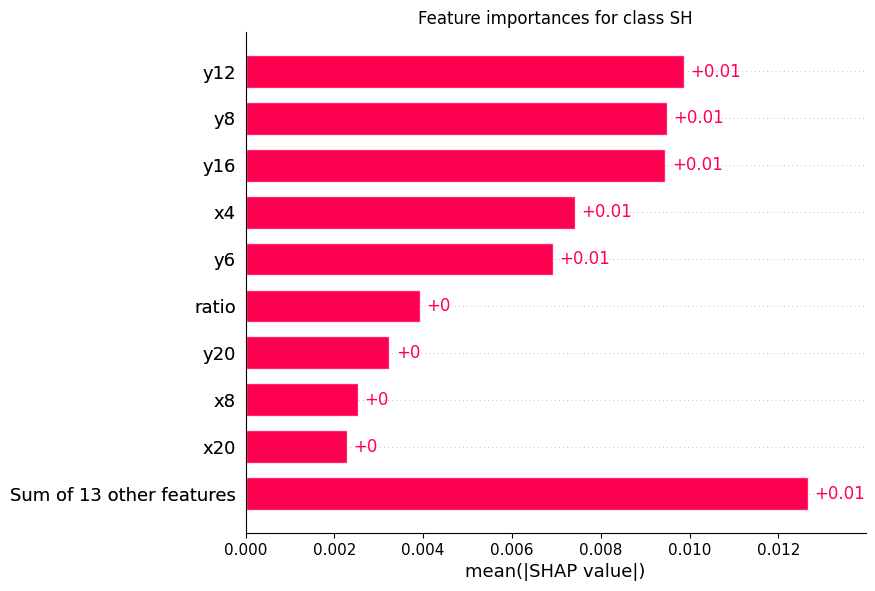

In [240]:
plt.title(f'Feature importances for class {sampled_y.tolist()[16]}')
shap.plots.bar(sv[:, :, 16])

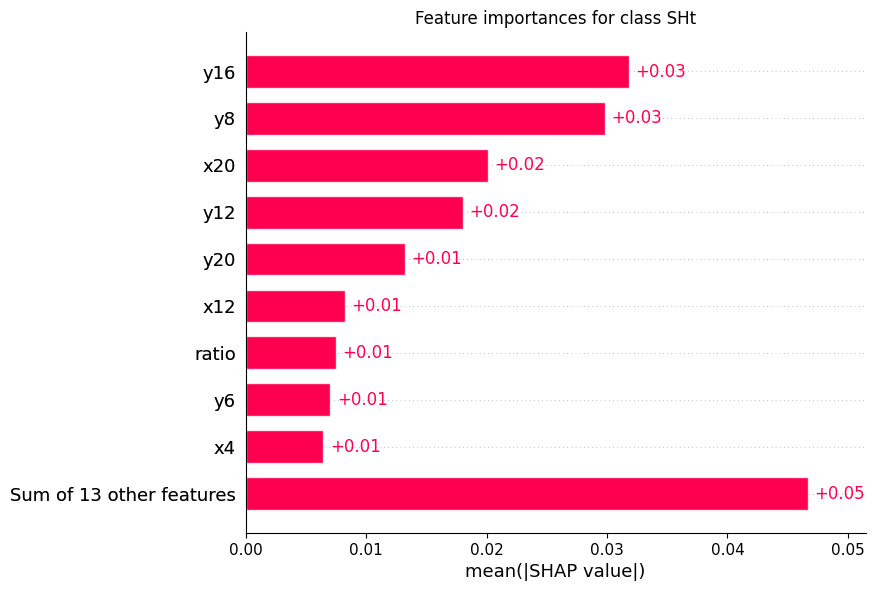

In [241]:
plt.title(f'Feature importances for class {sampled_y.tolist()[18]}')
shap.plots.bar(shap_values[:, :, 18])

From looking at the overall shap values, the biggest impact is given by ratio, then the xs of the tips of the fingers, then ious and then the ys.

## Run on test data ##

In [174]:
X_test = pipeline.transform(X_test)

In [184]:
ada_opt_res.score(X_test, y_test)

0.9727891156462585

In [182]:
pickle.dump(ada_opt_res, open('ada_opt.pkl','wb'))

#### A "zdrasti" ####
A gif of the model at work in which the first one to confuse two similar letters was me. (zdNrasti is my first official sign language typo)

![](./images/zdrasti_live.gif)

The code for this is in live_classification.py but it is still a WIP (very ugly and unoptimized)

Although the model scores a what would normally be an impressive 97% accuracy, in reality, it is far from perfect. D and K are still problematic. While K can be recognized due to the changing ratio during the movement, D fades into insignificance inbetween K and YA. Basically it can be hard to make the model recogniza your D sign. Some struggles persist with other statc-moving pairs as well, although not as prominent.

# Conclusion and room for growth #

The model recognizes most of the letters and, as expected, is most likely to make mistakes with those that differ in movement, rather than shape. It does well with small variations in angle, however, more training data could be collected to improve that even further. It performs not too slow in real time (despite the code for real-time not being optimized at all yet). 
There are more things that can be explored and tweaked like how many frames apart should the samples be taken, for many frames back should the IoU be taken or maybe even a more complex way of modelling that would classify among the static letters first and then classify movement. For the live version, I am yet to experiment with different confidence levels in live_classification.py and achieve acceptable behaviour when hands in frame are not attempting to make a sign.

### References: ###
<ol>
    <li><a href="https://www.youtube.com/watch?v=8YmTxIp2Gtg">Bulgarian Sign Language Youtube</a></li>
    <li><a href="https://ai.google.dev/edge/mediapipe/solutions/vision/hand_landmarker">Mediapipe Hand Landmarker</a></li>
    <li><a hred="https://www.grepmed.com/images/19374/dip-metacarpophalangeal-proximal-joint-interphalangeal">Hand joints picture</a></li>
</ol>